###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

An simple MLP training using graphs

In [1]:
import numpy as np
from graphs.core import Param
from graphs.core import DataHolder
from graphs.core import Graph
from graphs.nodes import linear_node
from graphs.nodes import bias_node
from graphs.nodes import sigmoid_node
from graphs.nodes import relu_node
from graphs.nodes import leaky_relu_node
from graphs.nodes import softmax_mce_node
from graphs.optimizers import AdamOptimizer
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
# Plotting function
def plot_boundary(h_node,X_node,
                  X_train,y_train,X_test,y_test,
                  poly=None,scaler=None,xlim=(0,1),ylim=(0,1)):
    # Creates an auxiliary graph
    graph = Graph()
    graph.build(h_node)
    # Generates mesh
    pts = 100
    x1 = np.linspace(xlim[0], xlim[1], pts)  # x1
    x2 = np.linspace(ylim[0], ylim[1], pts)  # x2
    x1, x2 = np.meshgrid(x1, x2)
    mesh = np.vstack((x1.flatten(), x2.flatten())).T
    if poly is not None:
        mesh = poly.transform(mesh)
    if scaler is not None:
        mesh = scaler.transform(mesh)
    # Training set
    if scaler is not None:
        temp = scaler.inverse_transform(X_train)
    else:
        temp = X_train
    plt.scatter(temp[:,0],temp[:,1],cmap='viridis',c=y_train.flatten(),s=50,edgecolor='k')
    # Boundary
    graph.feed({X_node: mesh})
    graph.forward()
    h = h_node.value
    indexes = set(range(h.shape[1]))
    for i in indexes:
        g = h[:,i] - h[:,list(indexes - {i})].max(axis=1)
        plt.contour(x1, x2, g.reshape((pts,pts)), levels = [0], colors='black')
    # Decision regions
    y_pred = h.argmax(axis=1).reshape((pts,pts))
    plt.contourf(x1, x2, y_pred, alpha = 0.10,cmap='viridis')
    # Test set
    graph.feed({X_node: X_test})
    graph.forward()
    y_pred = h_node.value.argmax(axis=1)
    correct = (y_pred == y_test.flatten())
    if scaler is not None:
        temp = scaler.inverse_transform(X_test)
    else:
        temp = X_test
    plt.scatter(temp[correct,0],temp[correct,1], marker='.', c='black', s=60)
    plt.scatter(temp[~correct,0],temp[~correct,1], marker='x', c='black', s=60)

In [3]:
# Loads dataset
predictors,responses = make_circles(noise=0.1, factor=0.5, random_state=1,n_samples=300)

In [4]:
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,responses,stratify=responses)

In [5]:
# Builds models inputs and params
_,d = X_train.shape
n = len(np.unique(y_train))
X_node = DataHolder()
y_node = DataHolder()

In [6]:
# Build hidden layers and all proper connections
hidden_config = [(30,'leaky')]
input_shape = (d,)
input_node = X_node

for config in hidden_config:
    # init weights and bias
    w_node = Param((input_shape[0],config[0]))
    b_node = Param((1,config[0]))
    # builds hidden layer
    r_node = linear_node(input_node,w_node)
    z_node = bias_node(r_node,b_node)
    if config[1] == 'sigmoid':
        h_node = sigmoid_node(z_node)
    elif config[1] == 'relu':
        h_node = relu_node(z_node)
    elif config[1] == 'leaky':
        h_node = leaky_relu_node(z_node)
    else:
        h_node = z_node
    # stores last node to connect to next layer
    input_node = h_node
    input_shape = (config[0],)

w_node = Param((input_shape[0],n))
b_node = Param((1,n))
r_node = linear_node(input_node,w_node)
z_node = bias_node(r_node,b_node)
J_node = softmax_mce_node(z_node,y_node)

In [7]:
# Graph helper object
graph = Graph()
graph.build(J_node).initialize()

In [8]:
# Computing the accuracy of the model with random weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  176.42338359664984
Accuracy (Training):  0.50
Accuracy (Test):  0.49


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


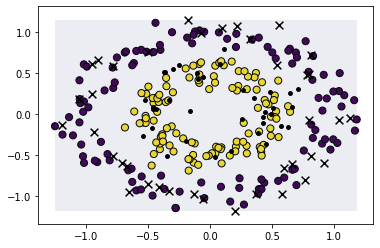

In [9]:
# Plots boundary
plot_boundary(J_node.h_node,X_node,
              X_train,y_train,X_test,y_test,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

In [10]:
# Training
start = time.perf_counter()
graph.feed({X_node: X_train, y_node: y_train})
niter,history = graph.minimize(optimizer=AdamOptimizer(alpha=1e-2))
end = time.perf_counter()
print('In {:} iteration ({:} secs) cost went from {:} to {:}'.format(niter,end-start,history[0],history[-1]))

In 1000 iteration (0.43731510000000107 secs) cost went from 176.42338359664984 to 0.42749543207756296


In [11]:
# Computing the accuracy of the model with trained weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  0.4267594837101573
Accuracy (Training):  1.00
Accuracy (Test):  0.99


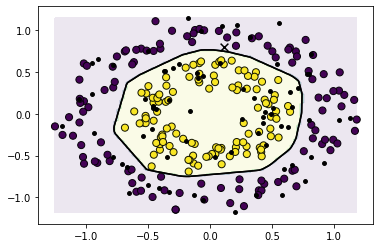

In [12]:
# Plots boundary
plot_boundary(J_node.h_node,X_node,
              X_train,y_train,X_test,y_test,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

In [13]:
# Running graph with training data
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
for operation in graph.post_order:
    if isinstance(operation,leaky_relu_node):
        X_hidden = operation.value
        break

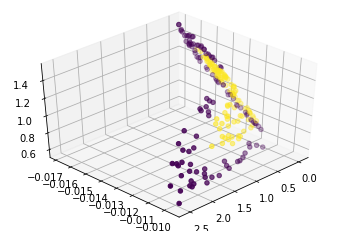

In [14]:
# Plot observations in the training set using the features learned
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hidden[:,0],X_hidden[:,1],X_hidden[:,2],c=y_train,s=20)
ax.view_init(elev=40, azim=45)

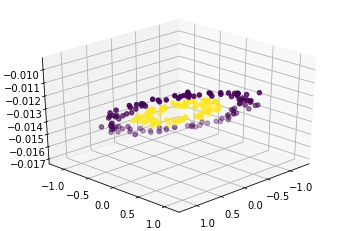

In [15]:
# Plot original features (only two) with respect to any of the new learned ones at the hidden layer
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0],X_train[:,1],X_hidden[:,1],c=y_train,s=20)
ax.view_init(azim=45)